## Pulling  Data

In [24]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import urllib3
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


[train_ds, valid_ds, test_ds] , info = tfds.load("malaria", 
                                                 split = ['train[:70%]', 'train[70%:85%]', 'train[85%:]'], 
                                                 shuffle_files=True, 
                                                 with_info=True)

NEW_HEIGHT = 64
NEW_WIDTH = 64
BATCH_SIZE = 100

In [25]:

def fix_image(ds):
    ds["image"] = tf.image.convert_image_dtype(ds["image"], tf.float32)
    ds["image"] = tf.image.resize_with_crop_or_pad(ds["image"], NEW_HEIGHT, NEW_WIDTH)
    return ds["image"], tf.one_hot(ds["label"], depth=2)  # One-hot encode the labels

fixed_train_ds = train_ds.map(fix_image).batch(BATCH_SIZE)
fixed_valid_ds = valid_ds.map(fix_image).batch(BATCH_SIZE)
fixed_test_ds = test_ds.map(fix_image).batch(BATCH_SIZE)

In [3]:
fixed_train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

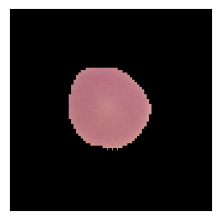

In [23]:
ds_size = info.splits["train"].num_examples
ds_names = info.features["label"].names
ds_classes = info.features["label"].num_classes

batch_image, batch_label = next(iter(fixed_train_d))

plt.figure(figsize= (16,12))

for i in range(4):
    ax = plt.subplot(4,4,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(batch_image[i])
    if batch_label[i]:
        plt.title(ds_names[1])
    else:
        plt.title(ds_names[0])

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Define the CNN architecture
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))  # Assuming RGB images
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Second convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Flatten the feature matrix
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax'))  # Assuming binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 31, 31, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0

In [76]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
)

In [59]:
class_weight = {0:0.5, 1: 0.5}
print(class_weight)

{0: 0.5, 1: 0.5}


The number of epochs is set to 50,while a callback function is written to invoke early stopping when the model’s validation accuracy reaches a maximum accuracy. 

In [77]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights=True)


### Training the Model

Finally, we have reached the training step for our CNN. We tell the method "fit" to use the training images (and associated labels) for 50 epochs and using the test sample as validation set. By default, the batch size is of 193 examples. We also tell the method to show progress bars by setting the value of "verbose.

In [78]:
model.fit(
    fixed_train_ds,
    epochs=50,
    validation_data=fixed_valid_ds,
    verbose=1,
    callbacks=[early_stopping]
   # class_weight=class_weight,
)

Epoch 1/50
193/193 [==============================] - 210s 1s/step - loss: 0.6314 - accuracy: 0.6992 - val_loss: 0.6956 - val_accuracy: 0.5149
Epoch 2/50
193/193 [==============================] - 220s 1s/step - loss: 0.5238 - accuracy: 0.7471 - val_loss: 0.6174 - val_accuracy: 0.5945
Epoch 3/50
193/193 [==============================] - 245s 1s/step - loss: 0.4777 - accuracy: 0.7709 - val_loss: 0.7791 - val_accuracy: 0.6276
Epoch 4/50
193/193 [==============================] - 221s 1s/step - loss: 0.4508 - accuracy: 0.7855 - val_loss: 1.2169 - val_accuracy: 0.6054
Epoch 5/50
193/193 [==============================] - 207s 1s/step - loss: 0.4270 - accuracy: 0.7962 - val_loss: 1.7336 - val_accuracy: 0.5546
Epoch 6/50
193/193 [==============================] - 215s 1s/step - loss: 0.4092 - accuracy: 0.8066 - val_loss: 1.1366 - val_accuracy: 0.6184
Epoch 7/50
193/193 [==============================] - 228s 1s/step - loss: 0.3939 - accuracy: 0.8175 - val_loss: 1.1342 - val_accuracy: 0.6651

### 4. EVALUATING THE MODEL'S PERFORMANCE

In [7]:
model = tf.keras.models.load_model("model.h5")

Let's display the accuracy reached in the validation sample (recall that we are  using a test sample; the validation and test are not the same).

In [8]:
acc = model.evaluate(fixed_test_ds)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

42/42 [==============================] - 10s 232ms/step - loss: 0.5666 - accuracy: 0.7284
Accuracy over validation: 72.84%


In [10]:

y_true = []
y_pred = []

for images, labels in fixed_test_ds:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 [==============================] - 0s 41ms/step


In [12]:
report = classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized'])
print(report)


              precision    recall  f1-score   support

  Uninfected       0.91      0.51      0.66      2086
 Parasitized       0.66      0.95      0.78      2048

    accuracy                           0.73      4134
   macro avg       0.78      0.73      0.72      4134
weighted avg       0.78      0.73      0.72      4134



In [13]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[1069 1017]
 [ 106 1942]]


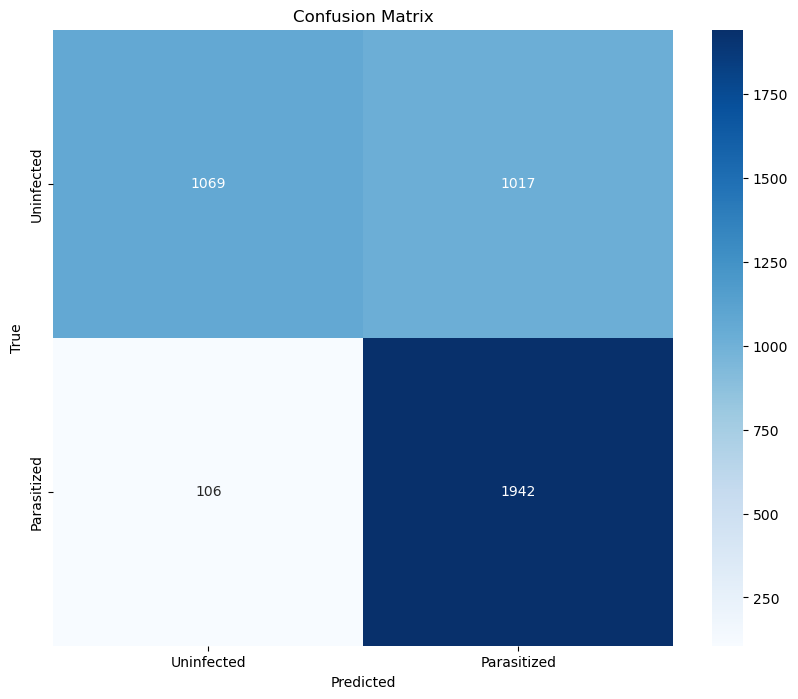

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
